### RAG Agéntico (Agentic RAG)

Sistema de Recuperación Aumentada Generativa con capacidades de razonamiento y toma de decisiones autónomas.

In [1]:
# Importar librerías para manejo de variables de entorno
import os  # Para acceder a variables de entorno del sistema
from dotenv import load_dotenv  # Para cargar variables desde archivo .env

# Cargar variables de entorno desde el archivo .env
load_dotenv()

# Configurar las API keys desde las variables de entorno
# GROQ_API_KEY: Para usar modelos de Groq (alternativa a OpenAI)
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

# OPENAI_API_KEY: Para usar embeddings y modelos de OpenAI
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [2]:
# Importar componentes necesarios para construir el sistema RAG
from langchain_community.document_loaders import WebBaseLoader  # Cargador de contenido web
from langchain_community.vectorstores import FAISS  # Base de datos vectorial FAISS
from langchain_openai import OpenAIEmbeddings  # Embeddings de OpenAI para vectorización
from langchain_text_splitters import RecursiveCharacterTextSplitter  # Divisor de texto recursivo

USER_AGENT environment variable not set, consider setting it to identify your requests.
c:\Udemy\RAGBootcamp\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Definir lista de URLs con documentación de LangGraph
# Estas URLs contienen tutoriales e información sobre LangGraph
urls = [
    "https://langchain-ai.github.io/langgraph/tutorials/introduction/",  # Introducción a LangGraph
    "https://langchain-ai.github.io/langgraph/tutorials/workflows/",  # Workflows en LangGraph
    "https://langchain-ai.github.io/langgraph/how-tos/map-reduce/"  # Patrón Map-Reduce en LangGraph
]

# Cargar documentos de cada URL usando WebBaseLoader
# List comprehension que itera sobre cada URL y carga su contenido
docs = [WebBaseLoader(url).load() for url in urls]

# Mostrar los documentos cargados
docs

[[Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/introduction/', 'title': 'Redirecting...', 'language': 'en'}, page_content='\n\n\n\n\nRedirecting...\n\n\n\n\n\n\nRedirecting...\n\n\n')],
 [Document(metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Workflows & agents', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='\n\n\n\n\n\n\n\n\n\n\n\nWorkflows & agents\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\n            \n            \nThese docs will be deprecated and removed with the release of LangGraph v1.0 in October 2025. Visit the v1.0 alpha docs\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            LangGraph\n          \n\n\n\n            \n              Workflows & agents\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          

In [4]:
# Aplanar la lista de documentos (de lista de listas a lista simple)
# docs es una lista de listas, necesitamos una lista plana de documentos
docs_list = [item for sublist in docs for item in sublist]

# Crear un divisor de texto con configuración específica
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Tamaño máximo de cada fragmento: 1000 caracteres
    chunk_overlap=100  # Superposición entre fragmentos: 100 caracteres para mantener contexto
)

# Dividir todos los documentos en fragmentos más pequeños (chunks)
# Esto facilita la búsqueda y recuperación precisa de información
doc_splits = text_splitter.split_documents(docs_list)

# Crear un vectorstore FAISS con todos los fragmentos
# FAISS convierte cada fragmento de texto en un vector numérico usando OpenAI Embeddings
vectorstore = FAISS.from_documents(
    documents=doc_splits,  # Fragmentos de texto a vectorizar
    embedding=OpenAIEmbeddings()  # Modelo de embeddings de OpenAI
)

# Convertir el vectorstore en un retriever
# El retriever permite buscar documentos relevantes dada una consulta
retriever = vectorstore.as_retriever()

In [5]:
# Probar el retriever con una consulta sobre LangGraph
# Busca documentos relevantes que respondan "¿qué es langgraph?"
retriever.invoke("what is langgraph")

[Document(id='bb97f3b3-3893-4435-b4ed-09b045117d75', metadata={'source': 'https://langchain-ai.github.io/langgraph/tutorials/workflows/', 'title': 'Workflows & agents', 'description': 'Build reliable, stateful AI systems, without giving up control', 'language': 'en'}, page_content='LangSmith Trace\nhttps://smith.langchain.com/public/abab6a44-29f6-4b97-8164-af77413e494d/r\nWhat LangGraph provides¶\nBy constructing each of the above in LangGraph, we get a few things:\nPersistence: Human-in-the-Loop¶\nLangGraph persistence layer supports interruption and approval of actions (e.g., Human In The Loop). See Module 3 of LangChain Academy.\nPersistence: Memory¶\nLangGraph persistence layer supports conversational (short-term) memory and long-term memory. See Modules 2 and 5 of LangChain Academy:\nStreaming¶\nLangGraph provides several ways to stream workflow / agent outputs or intermediate state. See Module 3 of LangChain Academy.\nDeployment¶\nLangGraph provides an easy on-ramp for deployment

In [6]:
### Convertir Retriever en Herramienta (Retriever Tool)
# Importar función para crear herramientas de recuperación
from langchain.tools.retriever import create_retriever_tool

# Crear una herramienta a partir del retriever
# Esto permite que un agente pueda usar el retriever como una herramienta
retriever_tool = create_retriever_tool(
    retriever,  # El retriever de la base de datos vectorial
    "retriever_vector_db_blog",  # Nombre único de la herramienta
    "Busca y obtiene información sobre Langgraph"  # Descripción de la herramienta
)

In [7]:
# Mostrar el objeto retriever_tool creado
# Esto permite verificar sus propiedades y configuración
retriever_tool

Tool(name='retriever_vector_db_blog', description='Busca y obtiene información sobre Langgraph', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x0000021FAE1CECA0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000021FAE1D0950>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x0000021FAE1CE2A0>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x0000021FAE1D0950>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'),

### Blogs de Langchain - Vector Store Separado

Creamos un segundo vectorstore con documentación específica de LangChain para dar al agente acceso a múltiples fuentes de conocimiento.

In [8]:
# Definir lista de URLs con documentación de LangChain
# Estas URLs contienen tutoriales específicos de LangChain
langchain_urls = [
    "https://python.langchain.com/docs/tutorials/",  # Página principal de tutoriales
    "https://python.langchain.com/docs/tutorials/chatbot/",  # Tutorial de chatbot
    "https://python.langchain.com/docs/tutorials/qa_chat_history/"  # Tutorial de Q&A con historial
]

# Cargar documentos de cada URL de LangChain
# Cada URL se carga y se almacena en una lista
docs = [WebBaseLoader(url).load() for url in langchain_urls]

# Mostrar los documentos cargados
docs

[[Document(metadata={'source': 'https://python.langchain.com/docs/tutorials/', 'title': 'Tutorials | 🦜️🔗 LangChain', 'description': 'New to LangChain or LLM app development in general? Read this material to quickly get up and running building your first applications.', 'language': 'en'}, page_content='\n\n\n\n\nTutorials | 🦜️🔗 LangChain\n\n\n\n\n\n\n\n\nSkip to main contentThese docs will be deprecated and no longer maintained with the release of LangChain v1.0 in October 2025. Visit the v1.0 alpha docsIntegrationsAPI ReferenceMoreContributingPeopleError referenceLangSmithLangGraphLangChain HubLangChain JS/TSv0.3v0.3v0.2v0.1💬SearchIntroductionTutorialsBuild a Question Answering application over a Graph DatabaseTutorialsBuild a simple LLM application with chat models and prompt templatesBuild a ChatbotBuild a Retrieval Augmented Generation (RAG) App: Part 2Build an Extraction ChainBuild an AgentTaggingBuild a Retrieval Augmented Generation (RAG) App: Part 1Build a semantic search engine

In [9]:
# Aplanar la lista de documentos de LangChain
# Convertir lista de listas en una lista simple de documentos
docs_list = [item for sublist in docs for item in sublist]

# Crear divisor de texto con la misma configuración
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Tamaño de cada fragmento: 1000 caracteres
    chunk_overlap=100  # Superposición: 100 caracteres
)

# Dividir los documentos de LangChain en fragmentos
doc_splits = text_splitter.split_documents(docs_list)

# Crear un vectorstore SEPARADO para documentación de LangChain
# Esto permite al agente distinguir entre fuentes de información
vectorstorelangchain = FAISS.from_documents(
    documents=doc_splits,  # Fragmentos de documentación de LangChain
    embedding=OpenAIEmbeddings()  # Embeddings de OpenAI
)

# Crear un retriever específico para LangChain
retrieverlangchain = vectorstorelangchain.as_retriever()

In [10]:
# Importar función para crear herramientas de retriever
from langchain.tools.retriever import create_retriever_tool

# Crear herramienta de recuperación para documentación de LangChain
retriever_tool_langchain = create_retriever_tool(
    retrieverlangchain,  # Retriever específico de LangChain
    "retriever_vector_langchain_blog",  # Nombre único de la herramienta
    "Busca y obtiene información sobre Langchain"  # Descripción para el agente
)

In [11]:
# Crear lista de todas las herramientas disponibles para el agente
# El agente podrá elegir entre estas dos fuentes de conocimiento:
# 1. retriever_tool - Información sobre LangGraph
# 2. retriever_tool_langchain - Información sobre LangChain
tools = [retriever_tool, retriever_tool_langchain]

### Flujo de Trabajo LangGraph (Workflow)

Construimos un grafo que implementa un sistema RAG Agéntico con:
- **Nodo Agente**: Decide qué herramienta usar
- **Nodo Retrieve**: Recupera documentos
- **Nodo Grade**: Evalúa relevancia de documentos
- **Nodo Rewrite**: Reformula la consulta si es necesaria
- **Nodo Generate**: Genera la respuesta final

In [12]:
# Importar tipos necesarios para definir el estado del agente
from typing import Annotated, Sequence  # Para anotaciones de tipo
from typing_extensions import TypedDict  # Para crear diccionarios tipados

# Importar tipos de mensajes de LangChain
from langchain_core.messages import BaseMessage

# Importar función para combinar mensajes en el estado
from langgraph.graph.message import add_messages


# Definir la clase de estado del agente
class AgentState(TypedDict):
    """
    Define el estado que fluye a través del grafo del agente.
    
    Attributes:
        messages: Secuencia de mensajes de la conversación.
                  La función add_messages define cómo procesar actualizaciones:
                  - Por defecto se reemplazaría el contenido
                  - add_messages indica "agregar al final" (append)
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [13]:
# Importar ChatGroq para usar modelos de Groq
from langchain_groq import ChatGroq

# Inicializar el modelo de lenguaje llama-3.1-8b-instant de Groq
# Este es un modelo de razonamiento avanzado (nota: genera etiquetas <think> para mostrar su proceso)
llm = ChatGroq(model="llama-3.1-8b-instant")

# Probar el modelo con un saludo simple
llm.invoke("Hi")

AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.026438925, 'prompt_time': 0.001595126, 'queue_time': 0.20346372, 'total_time': 0.028034051}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_e32974efee', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--fa63d70c-0c67-4564-b430-8864ba872426-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})

In [14]:
# Definir la función del nodo agente
def agent(state):
    """
    Invoca el modelo del agente para generar una respuesta basada en el estado actual.
    Dada la pregunta, decidirá si recuperar información usando las herramientas o simplemente terminar.

    Args:
        state (messages): El estado actual que contiene los mensajes de la conversación

    Returns:
        dict: El estado actualizado con la respuesta del agente agregada a los mensajes
    """
    # Imprimir indicador de que se está llamando al agente
    print("---LLAMANDO AL AGENTE---")
    
    # Obtener los mensajes del estado actual
    messages = state["messages"]
    
    # Inicializar el modelo de chat Groq
    model = ChatGroq(model="llama-3.1-8b-instant")
    
    # Vincular las herramientas al modelo
    # Esto permite que el modelo pueda decidir llamar a las herramientas
    model = model.bind_tools(tools)
    
    # Invocar el modelo con los mensajes actuales
    # El modelo decidirá si usar herramientas o responder directamente
    response = model.invoke(messages)
    
    # Retornar como lista porque se agregará a la lista existente de mensajes
    return {"messages": [response]}

In [15]:
# Importar tipos y librerías necesarias para los nodos del grafo
from typing import Annotated, Literal, Sequence  # Tipos para anotaciones
from typing_extensions import TypedDict  # Diccionarios tipados

# Importar hub de LangChain para acceder a prompts compartidos
from langchain import hub

# Importar tipos de mensajes
from langchain_core.messages import BaseMessage, HumanMessage

# Importar parser de salida para convertir respuestas a strings
from langchain_core.output_parsers import StrOutputParser

# Importar PromptTemplate para crear prompts personalizados
from langchain_core.prompts import PromptTemplate

# Importar Pydantic para validación de datos estructurados
from pydantic import BaseModel, Field

In [21]:
### Aristas Condicionales (Conditional Edges)
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determina si los documentos recuperados son relevantes para la pregunta.
    Esta función actúa como una arista condicional que dirige el flujo del grafo.

    Args:
        state (messages): El estado actual que contiene los mensajes

    Returns:
        str: Una decisión sobre si los documentos son relevantes o no
             - "generate": Los documentos son relevantes, proceder a generar respuesta
             - "rewrite": Los documentos no son relevantes, reformular la pregunta
    """

    # Imprimir indicador de verificación de relevancia
    print("---VERIFICANDO RELEVANCIA---")

    # Definir modelo de datos para la calificación
    class grade(BaseModel):
        """Puntuación binaria para verificación de relevancia."""
        binary_score: str = Field(description="Puntuación de relevancia 'yes' o 'no'")

    # Inicializar el modelo de lenguaje
    model = ChatGroq(model="llama-3.1-8b-instant")

    # Vincular el modelo con salida estructurada según el esquema 'grade'
    # Esto garantiza que la respuesta del LLM siga el formato definido
    llm_with_tool = model.with_structured_output(grade)

    # Crear el prompt para evaluar relevancia
    prompt = PromptTemplate(
        template="""Eres un evaluador que determina la relevancia de un documento recuperado respecto a una pregunta del usuario. \n 
        Aquí está el documento recuperado: \n\n {context} \n\n
        Aquí está la pregunta del usuario: {question} \n
        Si el documento contiene palabra(s) clave o significado semántico relacionado con la pregunta del usuario, califícalo como relevante. \n
        Da una puntuación binaria 'yes' o 'no' para indicar si el documento es relevante para la pregunta.""",
        input_variables=["context", "question"],
    )

    # Crear la cadena: prompt -> modelo con salida estructurada
    chain = prompt | llm_with_tool

    # Obtener los mensajes del estado
    messages = state["messages"]
    
    # Obtener el último mensaje (respuesta de la herramienta con documentos)
    last_message = messages[-1]

    # Obtener la pregunta original (primer mensaje del usuario)
    question = messages[0].content
    
    # Obtener los documentos recuperados del último mensaje
    docs = last_message.content

    # Invocar la cadena para calificar los documentos
    scored_result = chain.invoke({"question": question, "context": docs})

    # Extraer la puntuación binaria
    score = scored_result.binary_score

    # Decidir el siguiente paso según la puntuación
    if score == "yes":
        print("---DECISIÓN: DOCUMENTOS RELEVANTES---")
        return "generate"  # Proceder a generar respuesta
    else:
        print("---DECISIÓN: DOCUMENTOS NO RELEVANTES---")
        print(score)
        return "rewrite"  # Reformular la pregunta

In [22]:
# Definir la función para generar la respuesta final
def generate(state):
    """
    Genera la respuesta final basada en los documentos relevantes.

    Args:
        state (messages): El estado actual con los mensajes

    Returns:
         dict: El estado actualizado con la respuesta generada
    """
    # Imprimir indicador de generación
    print("---GENERANDO RESPUESTA---")
    
    # Obtener los mensajes del estado
    messages = state["messages"]
    
    # Obtener la pregunta original (primer mensaje)
    question = messages[0].content
    
    # Obtener el último mensaje que contiene los documentos relevantes
    last_message = messages[-1]

    # Extraer los documentos del último mensaje
    docs = last_message.content

    # Obtener el prompt RAG desde LangChain Hub
    # Este es un prompt optimizado para generación aumentada por recuperación
    prompt = hub.pull("rlm/rag-prompt")

    # Inicializar el modelo de lenguaje
    llm = ChatGroq(model="llama-3.1-8b-instant")

    # Función auxiliar para formatear documentos (si fuera necesario)
    def format_docs(docs):
        """Formatea una lista de documentos uniéndolos con saltos de línea"""
        return "\n\n".join(doc.page_content for doc in docs)

    # Crear la cadena RAG: prompt -> LLM -> parser de string
    rag_chain = prompt | llm | StrOutputParser()

    # Ejecutar la cadena con el contexto (documentos) y la pregunta
    response = rag_chain.invoke({"context": docs, "question": question})
    
    # Retornar la respuesta como nuevo mensaje
    return {"messages": [response]}

In [23]:
# Definir la función para reformular la consulta
def rewrite(state):
    """
    Transforma la consulta para producir una pregunta mejorada.
    Esto se usa cuando los documentos recuperados no son relevantes.

    Args:
        state (messages): El estado actual con los mensajes

    Returns:
        dict: El estado actualizado con la pregunta reformulada
    """

    # Imprimir indicador de transformación de consulta
    print("---TRANSFORMANDO CONSULTA---")
    
    # Obtener mensajes del estado
    messages = state["messages"]
    
    # Obtener la pregunta original
    question = messages[0].content

    # Crear mensaje para reformular la pregunta
    # Se le pide al LLM que razone sobre la intención semántica subyacente
    msg = [
        HumanMessage(
            content=f""" \n 
    Observa la entrada e intenta razonar sobre la intención semántica / significado subyacente. \n 
    Aquí está la pregunta inicial:
    \n ------- \n
    {question} 
    \n ------- \n
    Formula una pregunta mejorada: """,
        )
    ]

    # Inicializar el modelo
    model = ChatGroq(model="llama-3.1-8b-instant")
    
    # Invocar el modelo con el mensaje de reformulación
    response = model.invoke(msg)
    
    # Retornar la pregunta reformulada como nuevo mensaje
    return {"messages": [response]}

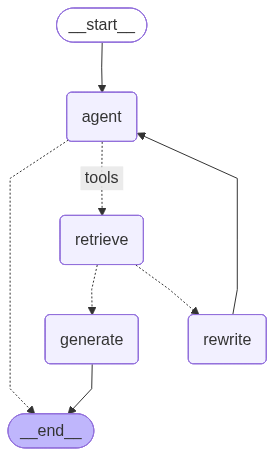

In [24]:
# Importar componentes para construir el grafo de LangGraph
from langgraph.graph import END, StateGraph, START  # Constantes y clase para grafo
from langgraph.prebuilt import ToolNode  # Nodo preconstruido para herramientas
from langgraph.prebuilt import tools_condition  # Condición para decidir si usar herramientas

# Definir un nuevo grafo con el estado del agente
workflow = StateGraph(AgentState)

# Definir los nodos entre los que el grafo circulará
# Cada nodo es una función que transforma el estado

# Nodo del agente - decide qué hacer
workflow.add_node("agent", agent)

# Nodo de recuperación - ejecuta las herramientas de retriever
retrieve = ToolNode([retriever_tool, retriever_tool_langchain])
workflow.add_node("retrieve", retrieve)

# Nodo de reformulación - mejora la pregunta si es necesario
workflow.add_node("rewrite", rewrite)

# Nodo de generación - crea la respuesta final cuando los docs son relevantes
workflow.add_node("generate", generate)

# Establecer el punto de entrada del grafo
# El flujo siempre comienza en el nodo "agent"
workflow.add_edge(START, "agent")

# Agregar arista condicional desde "agent"
# Decide si recuperar documentos o terminar
workflow.add_conditional_edges(
    "agent",
    # Función que evalúa la decisión del agente
    tools_condition,  # Verifica si el agente quiere usar herramientas
    {
        # Mapeo de condiciones a nodos
        "tools": "retrieve",  # Si quiere usar herramientas, ir a retrieve
        END: END,  # Si no necesita herramientas, terminar
    },
)

# Agregar arista condicional desde "retrieve"
# Después de recuperar, evalúa si los documentos son relevantes
workflow.add_conditional_edges(
    "retrieve",
    # Función que evalúa la relevancia
    grade_documents,  # Retorna "generate" o "rewrite"
)

# Arista desde "generate" al final
# Después de generar la respuesta, el flujo termina
workflow.add_edge("generate", END)

# Arista desde "rewrite" de vuelta a "agent"
# Después de reformular, vuelve al agente para intentar de nuevo
workflow.add_edge("rewrite", "agent")

# Compilar el grafo para hacerlo ejecutable
graph = workflow.compile()

# Visualizar el grafo
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [25]:
# Ejecutar el grafo con una pregunta sobre LangGraph
# El agente decidirá usar la herramienta apropiada (retriever_vector_db_blog)
graph.invoke({"messages": "¿Qué es Langgraph?"})

---LLAMANDO AL AGENTE---
---VERIFICANDO RELEVANCIA---
---DECISIÓN: DOCUMENTOS RELEVANTES---
---GENERANDO RESPUESTA---


{'messages': [HumanMessage(content='¿Qué es Langgraph?', additional_kwargs={}, response_metadata={}, id='3a6674e7-6700-48b4-9826-9338049d8014'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qws4g66jf', 'function': {'arguments': '{"query":"Langgraph ¿Qué es?"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 319, 'total_tokens': 341, 'completion_time': 0.028595165, 'prompt_time': 0.021190108, 'queue_time': 0.204424357, 'total_time': 0.049785273}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4cb846ce-b75e-430c-b0ad-7a82dfa3cf73-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'Langgraph ¿Qué es?'}, 'id': 'qws4g66jf', 'type': 'tool_call'}], usage_metadata={'input_tokens': 319, 'output_tokens': 22, 'total_tokens': 341}),
  ToolMessage(conten

In [26]:
# Ejecutar el grafo con una pregunta sobre LangChain
# El agente decidirá usar la herramienta apropiada (retriever_vector_langchain_blog)
graph.invoke({"messages": "¿Qué es Langchain?"})

---LLAMANDO AL AGENTE---


{'messages': [HumanMessage(content='¿Qué es Langchain?', additional_kwargs={}, response_metadata={}, id='6b1cc816-fbd4-4477-b896-728c892cb5bb'),
  AIMessage(content='(function=retriever_vector_langchain_blog>{"query": "Langchain"}}', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 319, 'total_tokens': 335, 'completion_time': 0.031568824, 'prompt_time': 0.019740557, 'queue_time': 0.203682077, 'total_time': 0.051309381}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ab04adca7d', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--b1c3f171-0161-432a-b67b-a0aeedbeff02-0', usage_metadata={'input_tokens': 319, 'output_tokens': 16, 'total_tokens': 335})]}

In [28]:
# Ejecutar el grafo con una pregunta fuera del dominio de conocimiento
# El agente decidirá NO usar herramientas y responderá directamente con su conocimiento
# Esta pregunta no está relacionada con LangGraph ni LangChain
graph.invoke({"messages": "¿What is Machine Learning?"})

---LLAMANDO AL AGENTE---
---VERIFICANDO RELEVANCIA---
---DECISIÓN: DOCUMENTOS NO RELEVANTES---
no
---TRANSFORMANDO CONSULTA---
---LLAMANDO AL AGENTE---


{'messages': [HumanMessage(content='¿What is Machine Learning?', additional_kwargs={}, response_metadata={}, id='f31d9454-3008-4953-aa20-220f6fb049e4'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xcn6cke4k', 'function': {'arguments': '{"query":"¿What is Machine Learning?"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 319, 'total_tokens': 341, 'completion_time': 0.029589285, 'prompt_time': 0.031656154, 'queue_time': 0.205738721, 'total_time': 0.061245439}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_e32974efee', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c25a6e3f-2d3c-435e-85bd-37248ad1056a-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': '¿What is Machine Learning?'}, 'id': 'xcn6cke4k', 'type': 'tool_call'}], usage_metadata={'input_tokens': 319, 'output_tokens': 22, 'total_tokens': 341